In [37]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional, Dict, Any, List,Annotated,Sequence
from langchain_core.messages import BaseMessage
from agents.youtube_post_agent import generate_youtube_content
from agents.topic_learning_agent import learning_agent
from agents.article_post_agent import article_post_content
from agents.router_agent import router_agent
from langgraph.graph.message import add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3 
from langgraph.store.sqlite import SqliteStore
from langgraph.types import interrupt, Command
from langgraph.checkpoint.mongodb import MongoDBSaver
from pymongo import MongoClient
from dotenv import load_dotenv
load_dotenv("utils/.env")

True

In [38]:

class AgentState(TypedDict):
    query:str
    messages: Annotated[Sequence[BaseMessage], add_messages]
    intermediate_data: Dict[str, Any]
    next_node:Optional[str]
    response:Optional[str]

In [39]:
def router_node(state:AgentState)-> AgentState:
    routing_result=router_agent(query=state['query'],chat_history=state.get("chat_history", []),intermediate_data=state.get("intermediate_data", {}))
    state["query"]=interrupt(routing_result.get('query',state["query"]))
    state["next_node"] = routing_result.get("next_node", "none")

    # if state["next_node"]=="none":
    #     prompt="Enter New Query:"
    #     new_query=interrupt(prompt)
    #     return {"query":new_query}
    #     # state["query"]=value
    for key in routing_result.get("reset_keys", []):
        if key in state["intermediate_data"]:
            state["intermediate_data"][key] = None
    return state

In [40]:
def youtube_content_node(state:AgentState)-> AgentState:
    state['response']= generate_youtube_content(query=state['query'],intermediate_data=state.get("intermediate_data", {}))
    return state

In [41]:
def course_finder_node(state:AgentState)-> AgentState:
    state['response']=learning_agent(query=state['query'],intermediate_data=state.get("intermediate_data", {}))
    return state

In [42]:
def article_content_node(state:AgentState)->AgentState:
    state['response']=article_post_content(query=state['query'],intermediate_data=state.get("intermediate_data", {}))
    return state

In [43]:
graph=StateGraph(AgentState)

In [44]:
graph.set_entry_point("Router_Agent")

In [45]:
graph.add_node("Router_Agent",router_node)
graph.add_node("youtube_content",youtube_content_node)
graph.add_node("article_content",article_content_node)
graph.add_node("course_finder",course_finder_node)

In [46]:
graph.add_conditional_edges(
    source="Router_Agent",
    path=lambda state : state['next_node'],
    path_map={
        "topic_learning_agent":"course_finder",
        "youtube_post_agent":"youtube_content",
        "article_post_agent":"article_content",
        "None":"Router_Agent"
    }
)

In [47]:
graph.set_finish_point("youtube_content")
graph.set_finish_point("course_finder")
graph.set_finish_point("article_content")

In [48]:
sqlite_conn=sqlite3.connect("checkpoint.sqlite",check_same_thread=False)
checkpointer=SqliteSaver(sqlite_conn)
checkpointer=MongoDBSaver.from_conn_string("localhost:27017")
config = {"configurable": {"thread_id": "69"}}

In [49]:
store=SqliteStore.from_conn_string(":memory:")

In [50]:
client = MongoClient("mongodb://localhost:27017")
memory = MongoDBSaver(client)

ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 68401abd4d1e62ceaff6a730, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [14]:
app=graph.compile(checkpointer=memory)

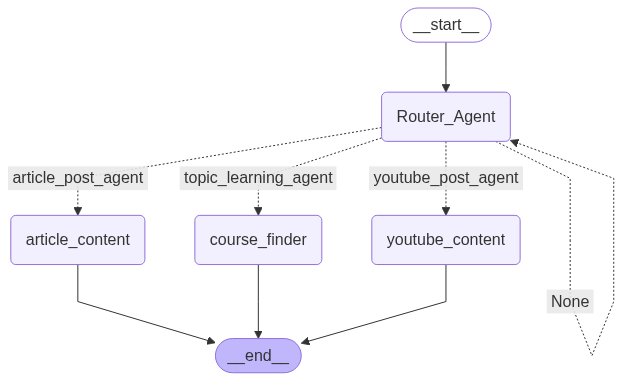

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
inputs={
    "query": "create image of cat",
    "chat_history": [],
    "intermediate_data": {},
    "next_node": None,
    "response": None
}

In [25]:
result=app.stream(inputs,config=config)

In [26]:
print(list(result))

2025-06-04 13:31:08.657 | INFO     | agents.router_agent:router_agent:22 - query: create image of cat


2025-06-04 13:31:09.503 | INFO     | agents.router_agent:router_agent:41 - response of Router agent: {'next_node': 'none', 'query': 'create image of cat', 'reset_keys': []}


[{'__interrupt__': (Interrupt(value='create image of cat', resumable=True, ns=['Router_Agent:a0259b71-a9ad-4870-4ee5-46d66ffca00b']),)}]


In [27]:
result=app.stream(Command(resume="find resources for vada pav",goto="Router_Agent"),config=config)

In [28]:
print(list(result))

2025-06-04 13:31:16.178 | INFO     | agents.router_agent:router_agent:22 - query: create image of cat
2025-06-04 13:31:16.985 | INFO     | agents.router_agent:router_agent:41 - response of Router agent: {'next_node': 'none', 'query': 'create image of cat', 'reset_keys': []}


[{'__interrupt__': (Interrupt(value='Enter New Query:', resumable=True, ns=['Router_Agent:a0259b71-a9ad-4870-4ee5-46d66ffca00b']),)}]


In [21]:
state_history = list(app.get_state_history(config=config))

In [22]:
state_history[-1].state

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '69', 'checkpoint_ns': '', 'checkpoint_id': '1f03f88e-93da-68c9-bfff-7c154c01cb92'}}, metadata={'source': 'input', 'writes': {'__start__': {'query': 'create linkedin content forhttps://www.youtube.com/watch?v=GToyQTGDOS4', 'chat_history': [], 'intermediate_data': {}, 'next_node': None, 'response': None}}, 'step': -1, 'parents': {}, 'thread_id': '69'}, created_at='2025-06-02T08:09:30.971955+00:00', parent_config=None, tasks=(PregelTask(id='aee24c63-b093-2d64-b7ea-ff70123f51d6', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'query': 'create linkedin content forhttps://www.youtube.com/watch?v=GToyQTGDOS4', 'intermediate_data': {}, 'next_node': None, 'response': None}),), interrupts=())

In [23]:
for i in app.get_state_history(config=config):
    print(i)

StateSnapshot(values={'query': 'create linkedin content forhttps://www.youtube.com/watch?v=GToyQTGDOS4', 'messages': [], 'intermediate_data': {'last_summary': 'Content Summary:\n{\'input_documents\': [Document(metadata={\'source\': \'https://www.youtube.com/watch?v=GToyQTGDOS4\'}, page_content=\'हाय गाइस, माय नेम इज नितीश एंड यू आर वेलकम टू माय YouTube चैनल। इस वीडियो में हम लोग एक ऐसे टॉपिक के बारे में बात करने जा रहे हैं जिसको आप सॉफ्टवेयर की दुनिया का यूनिवर्सल टॉपिक बुला सकते हो। यूनिवर्सल का मतलब कि आप सॉफ्टवेयर में किसी भी प्रोफाइल में काम कर रहे हो। आपको इस पर्टिकुलर टॉपिक की जरूरत जरूर पड़ेगी। भले ही आप सॉफ्टवेयर डेवलपर हो या वेब डेवलपर हो या फिर आप डेटा साइंटिस्ट हो या एमएलप्स इंजीनियर हो या फिर आप डेवोप्स में काम करते हो। इन सारे प्रोफाइल्स में आपको आज के टॉपिक की जरूरत पड़ेगी और आज का जो टॉपिक है उसका नाम है डॉकर। आई एम प्रीटी श्योर आपने इसके बारे में जरूर सुना होगा। ठीक है? अब बिकॉज़ ये यूनिवर्सल टॉपिक है और ये हर जगह यूज़ होता है। दैट इज व्हाई इसका जॉब पॉइंट ऑफ व्यू से और इं